# Imports and Settings

In [1]:
import os
import sys

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import statsmodels.api
from ydata_profiling import ProfileReport

/tmp/ipykernel_7333/740687576.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Allow imports from parent directory
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

In [3]:
from eda_utils import *

# Loading

In [4]:
%%time
df = pd.read_csv("../data/SBAnational.csv")

<timed exec>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 4.74 s, sys: 14 s, total: 18.8 s
Wall time: 20.7 s


# Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

# Removing Leaking Features

In [6]:
target_leaking_cols = [
    "ChgOffDate", "DisbursementDate", "DisbursementGross", "BalanceGross", "ChgOffPrinGr"
]
df = df.drop(columns = target_leaking_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  899164 non-null  int64  
 1   Name           899150 non-null  object 
 2   City           899134 non-null  object 
 3   State          899150 non-null  object 
 4   Zip            899164 non-null  int64  
 5   Bank           897605 non-null  object 
 6   BankState      897598 non-null  object 
 7   NAICS          899164 non-null  int64  
 8   ApprovalDate   899164 non-null  object 
 9   ApprovalFY     899164 non-null  object 
 10  Term           899164 non-null  int64  
 11  NoEmp          899164 non-null  int64  
 12  NewExist       899028 non-null  float64
 13  CreateJob      899164 non-null  int64  
 14  RetainedJob    899164 non-null  int64  
 15  FranchiseCode  899164 non-null  int64  
 16  UrbanRural     899164 non-null  int64  
 17  RevLineCr      894636 non-nul

# Other Columns to Drop?

## ⚠️ `LoanNr_ChkDgt` [NOT DROPPED BEFORE MODELING]

It seems to be the id of each row.

Hence, it shouldn't carry any information and should be discarded.

In [7]:
# df = df.drop(columns="LoanNr_ChkDgt")

# df.info()

## 🤔 `Name` [NOT DROPPED BEFORE MODELING]

`Name` doesn't seem to be relevant.

Moreover, there's a huge amount of different modalities.

In [8]:
df.Name.nunique()

779583

👉 Hence, **it seems reasonable to drop it**.

In [9]:
# df = df.drop("Name", axis=1)
# df.info()

## `City` or `Zip`?

In [10]:
df.City.isna().sum()

30

In [11]:
df.City.nunique()

32581

In [12]:
df.City.apply(lambda s: isinstance(s, float)).sum()

30

In [13]:
df.City.str.contains("\d+", regex=True).sum()

214

In [14]:
df = df.dropna(subset=['City'])

In [15]:
df[df.City.str.contains("\d+", regex=True)]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
233,1001873009,MILL PRINTING & LITHO CORP,WHITE PLAINS *102,NY,10603,HSBC BK USA NATL ASSOC,NY,0,19-Jun-80,1980,...,2.0,0,0,0,0,N,N,CHGOFF,"$500,000.00","$450,000.00"
1814,1012114006,LINCOLN CUSTOM CABINETS,"MIDDLESEX, NJ 08846",NJ,8846,"TD BANK, NATIONAL ASSOCIATION",NJ,337110,5-Mar-97,1997,...,1.0,0,0,1,0,N,N,P I F,"$275,000.00","$206,250.00"
7243,1049263002,DONALD HUNTER CONSTRUCTION,"BX. 10970, ROCK HILL",SC,29731,BANK OF AMERICA NATL ASSOC,SC,0,10-Sep-80,1980,...,2.0,0,0,0,0,N,N,CHGOFF,"$400,000.00","$360,000.00"
21315,1158074010,"WA-LU AVIATION, INC.",107 E CHURCH ST,NC,27828,SOUTHERN BK & TR CO,NC,0,23-Apr-97,1997,...,1.0,0,0,1,0,N,N,P I F,"$10,000.00","$7,500.00"
30484,1229964004,"CITY LINE B.R., INC.",7606 CITY LINE AVENUE,PA,19151,WELLS FARGO BANK NATL ASSOC,SD,445299,13-May-97,1997,...,2.0,0,0,9050,0,N,Y,P I F,"$100,000.00","$80,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873359,9435493006,CECIL PRINTING,4825 POPLAR AVE,TN,38119,REGIONS BANK,AL,0,2-Aug-96,1996,...,1.0,0,0,1,0,0,N,P I F,"$225,000.00","$168,750.00"
883108,9615503004,PLUTO'S,SAN FRANCISC0,CA,94122,WESTAMERICA BANK,CA,0,7-Oct-96,1997,...,1.0,0,0,1,0,N,N,P I F,"$210,000.00","$157,500.00"
884925,9676163002,"JAN S. LUKAC MD, INC.",ONE SAMSONE STREET #2300,CA,92621,CITIBANK INTERNATIONAL,CA,0,21-Oct-96,1997,...,1.0,0,0,1,0,0,N,P I F,"$70,000.00","$49,000.00"
885335,9690723000,"VERANDA INTERIORS, INC.",A452638533,NaN,76645,PROSPERITY BANK,TX,0,24-Oct-96,1997,...,1.0,0,0,1,0,N,N,P I F,"$100,000.00","$80,000.00"


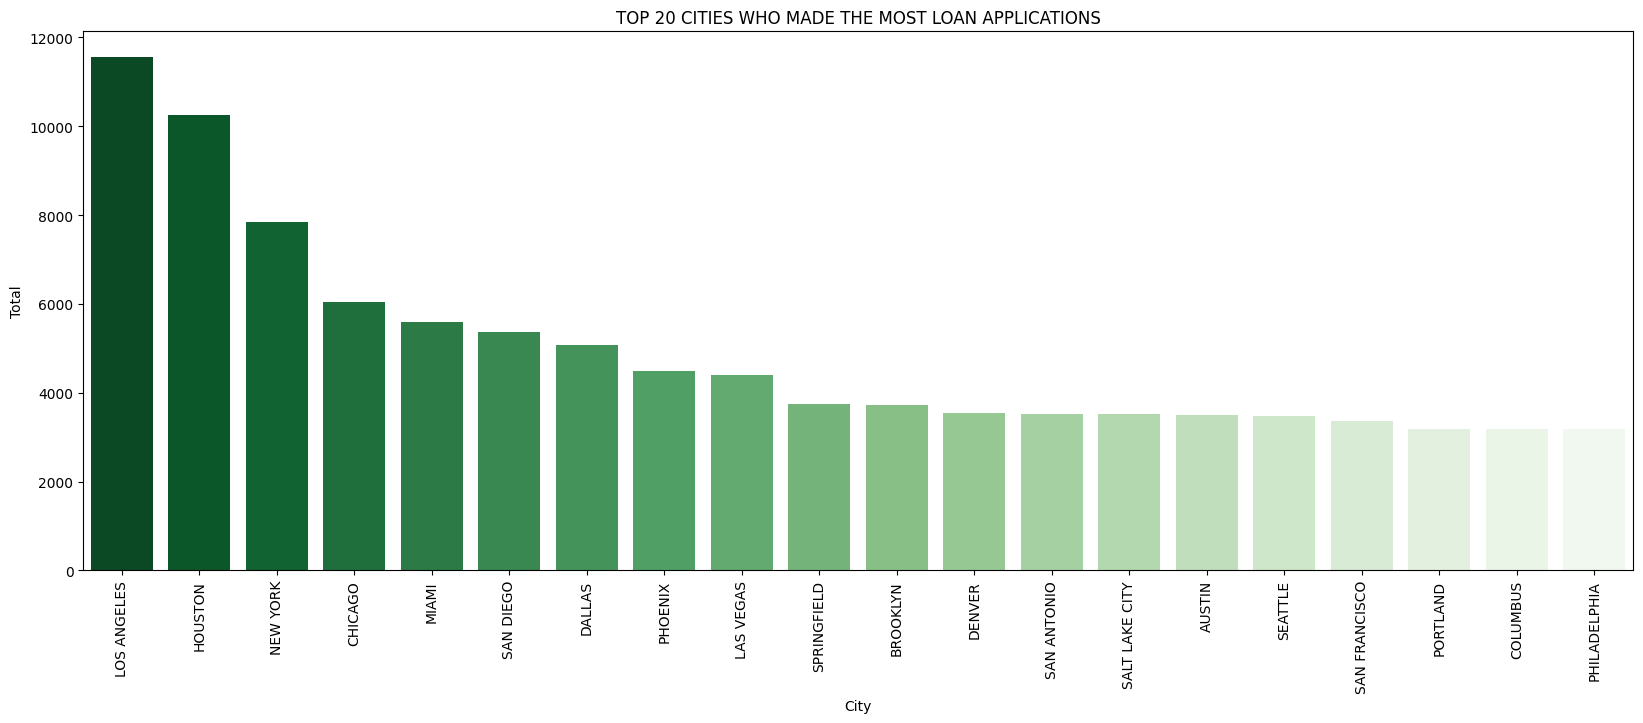

In [16]:
# TOP 20 des Villes (Count=Nb de demandes de prêts)
df.groupby("City").count().sort_values(by="State", ascending=False).head(10)
top10_city = df.groupby("City").count().sort_values(by="State", ascending=False).reset_index()
top10_city = top10_city[["City", "State"]]
top10_city = top10_city.rename(columns={"State" : "Total_Loan_Applications"})
top10_city.head(20)

test = df.groupby("City").count().reset_index()
test = test.rename(columns={"State": "Total"})
test_top = test.sort_values(by="Total", ascending=False).head(20)
test_top = test_top[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_top, x='City', y="Total", palette="Greens_r")
plt.xticks(rotation='vertical')
plt.show()

In [17]:
df.Zip.isna().sum()

0

In [18]:
df.Zip.nunique()

33611

👉 `Zip` has no missing values and seem to carry more information than `City`.

Hence, it could be one or the other.

👉 **Finally we will drop `Zip`**

In [19]:
df = df.drop(columns="Zip")

### ❌ Encoding City

Anyway, these features are categorical, despite of `Zip` being an integer, with a huge amount of modalities. Therefore, we should envision ways to encode them efficiently:
- Binary Encoding,
- Feature Hashing,
- Target Encoding.

# Duplicates and Missing Values

## Duplicates

In [20]:
df.duplicated().sum()

0

👉 **There are a few duplicates**.

## Missing Values

### Cartography

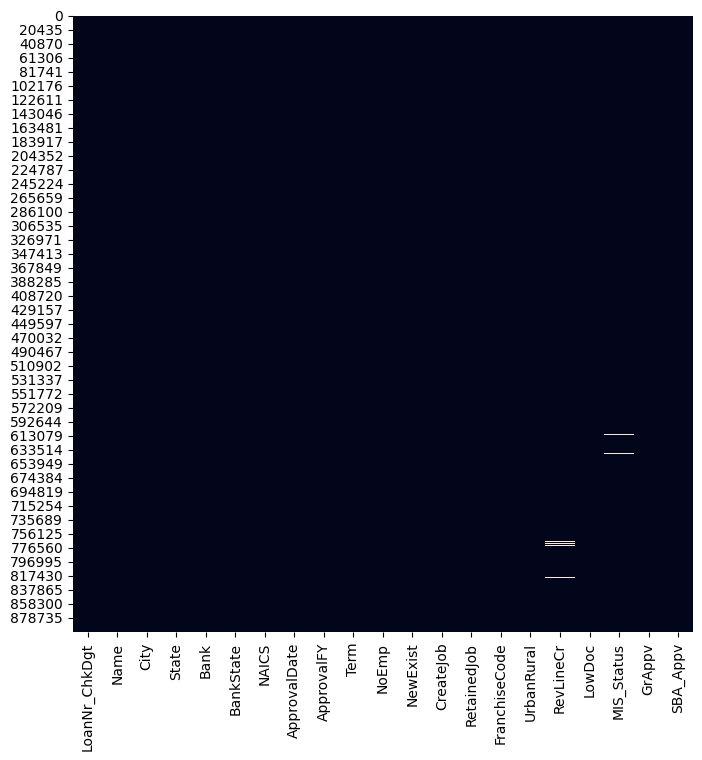

CPU times: user 13.2 s, sys: 17.9 s, total: 31.1 s
Wall time: 31.5 s


In [21]:
%%time
plt.figure(figsize=(8, 8))
sns.heatmap(df.isna(), cbar=None)
plt.show()

Missing Values seem relatively "marginal", and limited to spotted columns.

### Estimation

In [22]:
def quantify_NaNs(df: pd.DataFrame, col: str) -> None:
    """
    Display a report about NaN values (encoded as np.nan).
    """
    number = df[col].isna().sum()
    ratio = df[col].isna().mean()
    title = f"Nan Values for feature: {col}"
    number_display = f"Number: {number:,}"
    ratio_display = f"Proportion: {ratio * 100:.2f}%"
    endline = "-" * max(len(number_display), len(ratio_display), len(title))
    print(title)
    print(number_display)
    print(ratio_display)
    print(endline)

In [23]:
quantify_NaNs(df, "Bank")

Nan Values for feature: Bank
Number: 1,557
Proportion: 0.17%
----------------------------


In [24]:
nan_cols = ["Bank", "BankState", "RevLineCr", "LowDoc", "MIS_Status"]
for nan_col in nan_cols:
    quantify_NaNs(df, nan_col)

Nan Values for feature: Bank
Number: 1,557
Proportion: 0.17%
----------------------------
Nan Values for feature: BankState
Number: 1,564
Proportion: 0.17%
---------------------------------
Nan Values for feature: RevLineCr
Number: 4,528
Proportion: 0.50%
---------------------------------
Nan Values for feature: LowDoc
Number: 2,582
Proportion: 0.29%
------------------------------
Nan Values for feature: MIS_Status
Number: 1,997
Proportion: 0.22%
----------------------------------


👉 **All these features are categorical**.

### ⬇️ Global Strategy for Missing Values

- `Bank` and `BankState` as `missing`
- `RevLineCR`: `"O"` for "Others"
- `LowDoc`: ❌ `"Missing"`

⚠️ Should consider to include it in Pipeline

# Cleaning and Encoding Features One by One

## `City` ➡️ ❓

In [25]:
df.City.isna().sum()

0

## `State` 🤚 (a few missing values) ➡️ One-Hot-Encoding

In [26]:
df.State.isna().sum()

14

In [27]:
df.query("State.isna()")

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
35517,1270833006,SO. JERSEY DANCE/MERRYLEES,PENNSVILLE,NaN,NaN,NaN,0,28-Jul-81,1981,120,...,2.0,0,0,0,0,N,N,NaN,"$15,000.00","$15,000.00"
49244,1380800010,TRYON COATS & LEATHER,JOHNSTOWN NY,NaN,KEYBANK NATIONAL ASSOCIATION,NY,0,18-May-66,1966,282,...,0.0,0,0,0,0,N,N,CHGOFF,"$60,000.00","$54,000.00"
264664,2850643009,CENTURY 21 PHILLIPS REALTY,CAMERON PARK,NaN,SBA - EDF ENFORCEMENT ACTION,CO,0,12-Feb-87,1987,240,...,1.0,0,19,0,0,N,N,P I F,"$83,000.00","$83,000.00"
306274,3113583009,THE COMPUTER EDGE,"BOX 267, APO AP",NaN,RTC/WESTPORT SAVINGS BANK,CA,541511,21-Jan-88,1988,73,...,1.0,0,0,0,0,N,N,CHGOFF,"$50,000.00","$45,000.00"
328526,3280213000,KING'S TRUCK WASH,WICHITA,NaN,SOUTH CENT. KANSAS ECONOMIC DE,KS,811192,5-Aug-88,1988,120,...,2.0,10,7,0,0,N,N,P I F,"$119,000.00","$119,000.00"
351072,3445553007,JAMES A. NICHOLS,"1542,TABUK,SAUDI ARABIA",NaN,WELLS FARGO BANK NATL ASSOC,TX,532230,19-May-89,1989,16,...,2.0,0,0,0,0,N,N,P I F,"$60,000.00","$54,000.00"
366139,3556993002,"GOLF SHOES UNLIMITED, INC.",PALM BEACH GARDENS,NaN,"BEAL BANK, SSB",TX,451110,19-Oct-89,1990,84,...,2.0,0,0,1,0,N,N,P I F,"$75,000.00","$67,500.00"
366158,3557093005,CASCO SERVICE,CASCO,NaN,UNION STATE BANK,WI,0,19-Oct-89,1990,204,...,1.0,0,0,1,0,N,N,P I F,"$300,000.00","$252,600.00"
367007,3563473008,P & P TOOL INC,SOMERSET,NaN,FIRST BANK OF BALDWIN,WI,0,26-Oct-89,1990,240,...,1.0,0,0,1,0,N,N,P I F,"$82,000.00","$73,800.00"
379174,3664443009,WILLIAMS JEWELERS,SALT LAKE CITY,NaN,ZIONS FIRST NATIONAL BANK,UT,448310,14-Dec-89,1990,60,...,1.0,0,0,1,0,N,N,P I F,"$250,000.00","$212,500.00"


❌ Graph is done

## `Bank` ❌ Imputer

In [28]:
# As a reminder
quantify_NaNs(df, "Bank")

Nan Values for feature: Bank
Number: 1,557
Proportion: 0.17%
----------------------------


👉 Let's **encode them as "Missing"**.

In [29]:
df.Bank = df.Bank.fillna("Missing")

In [30]:
# Check-Out
quantify_NaNs(df, "Bank")

Nan Values for feature: Bank
Number: 0
Proportion: 0.00%
----------------------------


In [31]:
df.Bank.nunique()

5803

In [32]:
(df.Bank.value_counts() > 1).sum()

4880

### Options (❌ Include links to transformers)

👉 **Possible Options are:**
- One-Hot-Encoding with a beforehand preprocess, meaning:
  - Deciding on a number of modalities (bank names) to keep
  - Filtering `df` and tagging remaining banks as "Other" (exclude "missing"?)
- Binary Encoding
- Feature Hashing
- [**Target encoding**](https://snippets.cacher.io/snippet/4b06c26e3c42f10f0e5b)

## BankState ➡️ One-Hot-Encoding

The missing values are corresponding to the previous ones.

Hence, we'll opt for a similar imputing.

In [33]:
df.BankState = df.BankState.fillna("Missing")

In [34]:
df.BankState.unique()

array(['OH', 'IN', 'OK', 'FL', 'DE', 'SD', 'AL', 'CT', 'GA', 'OR', 'MN',
       'RI', 'NC', 'TX', 'MD', 'NY', 'TN', 'SC', 'MS', 'MA', 'LA', 'IA',
       'VA', 'CA', 'IL', 'KY', 'PA', 'MO', 'WA', 'MI', 'UT', 'KS', 'WV',
       'WI', 'AZ', 'NJ', 'CO', 'ME', 'NH', 'AR', 'ND', 'MT', 'ID',
       'Missing', 'WY', 'NM', 'DC', 'NV', 'NE', 'PR', 'HI', 'VT', 'AK',
       'GU', 'AN', 'EN', 'VI'], dtype=object)

## 👉 EDA Column: `SameState`

Its purpose is to compare the `State` and `BankState` variables.

In [35]:
df["SameState"] = df.State == df.BankState

In [36]:
df.SameState

0         False
1          True
2          True
3          True
4          True
          ...  
899159    False
899160    False
899161     True
899162     True
899163     True
Name: SameState, Length: 899134, dtype: bool

## NAICS ➡️ One-Hot-Encoding

In [37]:
quantify_NaNs(df, "NAICS")

Nan Values for feature: NAICS
Number: 0
Proportion: 0.00%
-----------------------------


☝️ There doesn't seem to be any missing values, but... 

In [38]:
df.NAICS.nunique()

1312

In [39]:
df.NAICS.unique()

array([451120, 722410, 621210, ..., 315280, 922140, 221121])

In [40]:
df.NAICS.value_counts(normalize=True)

NAICS
0         0.224569
722110    0.031129
722211    0.021630
811111    0.016221
621210    0.015624
            ...   
927110    0.000001
327410    0.000001
314992    0.000001
922110    0.000001
325192    0.000001
Name: proportion, Length: 1312, dtype: float64

🔎 **There are around 22% missing values, encoded as `0`**.

👉 **We'll assign them to an `"unknown"` category**.

In [41]:
NAICS_MAPPING = {
    "0": "unknown",
    "11": "agriculture_forestry_fishing_and_hunting",
    "21": "mining_quarrying_and_oil_and_gas_extraction",
    "22": "utilities",
    "23": "construction",
    "31": "manufacturing",
    "32": "manufacturing",
    "33": "manufacturing",
    "42": "wholesale_trade",
    "44": "retail_trade",
    "45": "retail_trade",
    "48": "transportation_and_warehousing",
    "49": "transportation_and_warehousing",
    "51": "information",
    "52": "finance_and_insurance",
    "53": "real_estate_and_rental_and_leasing",
    "54": "professionnal_scientific_and_technical_services",
    "55": "management_of_companies_and_entreproses",
    "56": "administrative_and_support_and_waste_management_and_remediation_services",
    "61": "educational_services",
    "62": "health_care_and_social_assistance",
    "71": "arts_entertainment_and_recreation",
    "72": "accomodation_and_food_services",
    "81": "other_services_except_public_administration",
    "92": "public_administration"
}

def map_NAICS_to_cats(n: int) -> str:
    """Map a NAICS integer to its counterpart category"""
    cat_digits = str(n)[:2]
    return NAICS_MAPPING.get(cat_digits)

In [42]:
(df.NAICS
 .map(map_NAICS_to_cats)
 .value_counts(normalize=True)
 .mul(100)
)

NAICS
unknown                                                                     22.456942
retail_trade                                                                14.152618
other_services_except_public_administration                                  8.076438
professionnal_scientific_and_technical_services                              7.581740
manufacturing                                                                7.566058
accomodation_and_food_services                                               7.518345
construction                                                                 7.412243
health_care_and_social_assistance                                            6.157703
wholesale_trade                                                              5.421105
administrative_and_support_and_waste_management_and_remediation_services     3.635165
transportation_and_warehousing                                               2.505856
arts_entertainment_and_recreation               

In [43]:
df.NAICS = df.NAICS.map(map_NAICS_to_cats)

❌ Add graph

## `ApprovalDate` ➡️ Feature Engineering

🔎 **This is a column containing dates (we also have the corresponding year) encoded as strings**

👉 **We will extract `ApprovalMonth` and `ApprovalDoW` (day of week) of this column, then drop it**.

### Transtype to Dates

#### Exploration

In [44]:
df.ApprovalDate

0         28-Feb-97
1         28-Feb-97
2         28-Feb-97
3         28-Feb-97
4         28-Feb-97
            ...    
899159    27-Feb-97
899160    27-Feb-97
899161    27-Feb-97
899162    27-Feb-97
899163    27-Feb-97
Name: ApprovalDate, Length: 899134, dtype: object

In [45]:
# Checking months
(df.ApprovalDate
 .str.split("-")
 .map(lambda lis: lis[1])
 .unique()
)

array(['Feb', 'Jun', 'Oct', 'Mar', 'Apr', 'May', 'Jul', 'Aug', 'Sep',
       'Nov', 'Dec', 'Jan'], dtype=object)

In [46]:
# Checking days
print(sorted(df.ApprovalDate
 .str.split("-")
 .map(lambda lis: int(lis[0]))
 .unique()
))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [47]:
# Checking years
print(sorted(df.ApprovalDate
 .str.split("-")
 .map(lambda lis: int(lis[2]))
 .unique()
))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 61, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [48]:
dates_69 = df.query("ApprovalDate.str.endswith('69')").ApprovalDate
dates_69

726149    28-Apr-69
738410    31-Jan-69
747668    13-Oct-69
754386     9-Oct-69
Name: ApprovalDate, dtype: object

#### ⚠️ WARNING

In [49]:
pd.to_datetime(dates_69)

/tmp/ipykernel_7333/2825988936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(dates_69)


726149   2069-04-28
738410   2069-01-31
747668   2069-10-13
754386   2069-10-09
Name: ApprovalDate, dtype: datetime64[ns]

☝️ These results show the purpose of the warning: specify that, **without a proper date format, the dates risk to be badly encoded with a badly inferred format**.

👉 Proper format found thanks to [**this documentation**](https://foragoodstrftime.com/)

In [50]:
pd.to_datetime(dates_69, format="%d-%b-%y")

726149   1969-04-28
738410   1969-01-31
747668   1969-10-13
754386   1969-10-09
Name: ApprovalDate, dtype: datetime64[ns]

#### Clean Transtyping

In [51]:
df.ApprovalDate = pd.to_datetime(df.ApprovalDate, format="%d-%b-%y")

☝️ Notice that **there's no longer any warning**.

In [52]:
df.ApprovalDate

0        1997-02-28
1        1997-02-28
2        1997-02-28
3        1997-02-28
4        1997-02-28
            ...    
899159   1997-02-27
899160   1997-02-27
899161   1997-02-27
899162   1997-02-27
899163   1997-02-27
Name: ApprovalDate, Length: 899134, dtype: datetime64[ns]

In [53]:
df.sample()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,SameState
141399,2032855003,KHURANA ENTERPRISES INC,COLONIA,NJ,"PNC BANK, NATIONAL ASSOCIATION",DE,arts_entertainment_and_recreation,2006-09-22,2006,47,...,0,5,0,1,Y,N,CHGOFF,"$15,000.00","$7,500.00",False


### Feature Engineering

👉 Based on this feature, **we will create two new ones, being `ApprovalMonth` and `ApprovalDayOfWeek`**.

In [54]:
df['ApprovalMonth'] = df.ApprovalDate.dt.month
print(sorted(df.ApprovalMonth.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [55]:
# Répartition en pourcentage des modalités
(df.ApprovalMonth
 .value_counts(normalize=True)
 .map(lambda x: round(x * 100, 2))
 .reset_index()
 .rename(columns={
     'ApprovalDate': 'ApprovalMonth',
     'proportion': 'percentage'
 })
 .sort_values(by="ApprovalMonth")
)

,ApprovalMonth,percentage
10,1,7.46
11,2,7.38
0,3,9.30
2,4,8.92
5,5,8.59
4,6,8.71
6,7,8.51
3,8,8.76
1,9,9.24
8,10,7.76


In [56]:
df['ApprovalDoW'] = df.ApprovalDate.dt.dayofweek
print(sorted(df.ApprovalDoW.unique()))

[0, 1, 2, 3, 4, 5, 6]


☝️ **With this encoding, `0` is for monday and so on...**

In [57]:
# Répartition en pourcentage des modalités
(df.ApprovalDoW
 .value_counts(normalize=True)
 .map(lambda x: round(x * 100, 2))
 .reset_index()
 .rename(columns={
     'ApprovalDate': 'ApprovalDoW',
     'proportion': 'percentage'
 })
 .sort_values(by="ApprovalDoW")
)

,ApprovalDoW,percentage
4,0,15.69
3,1,20.32
1,2,20.93
2,3,20.81
0,4,21.89
5,5,0.32
6,6,0.04


### 🔩 Next Step: Cyclical Encoding

This will be performed within pipeline in order to be able to find trends in *month* data.

The same will obviously be done with *day of week*.

🌐 [**Lien vers le code du transformer**](https://snippets.cacher.io/snippet/bade07859818be3395cd)

### Reordering Columns

To make all date-related columns next to each other.

In [58]:
df = df[['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 'SameState', 'NAICS',
       'ApprovalDate', 'ApprovalMonth', 'ApprovalDoW', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'MIS_Status', 'GrAppv', 'SBA_Appv']]

## `ApprovalFY`

### Exploration

In [59]:
years = df.ApprovalFY.unique()
years

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1962, 1982, 1965, 1966, 1983, 1973, 1984, 2007,
       1985, 1986, 1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010,
       1967, 2011, 1992, 1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977,
       1976, 1968, '2004', '1994', '1979', '1976', '1967', '1975', '1974',
       '1977', '1981', '1982', '1983', '1984', '1978', '1980', '1968',
       '1976A', '1969', '1995', '1970', '2005', '1996', '1971', 1996,
       1971], dtype=object)

🔎 Unfortunately, there are **mixed types**, but **there is worse**...

In [60]:
str_years = [year for year in years if isinstance(year, str)]
print(sorted(str_years))

['1967', '1968', '1969', '1970', '1971', '1974', '1975', '1976', '1976A', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1994', '1995', '1996', '2004', '2005']


In [61]:
int_years = [year for year in years if isinstance(year, int)]
print(sorted(int_years))

[1962, 1965, 1966, 1967, 1968, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


🔎 There are **overlaps in these mixed types**, which, after thinking twice about it, won't do any harm... But **there is an oddity**...

### '1976' and '1976A' 🤔

👉 **What could `1976A` refer to?**

In [62]:
df_1976A = df.query("ApprovalFY == '1976A'")
df_1976A

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalDate,ApprovalMonth,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
699732,7268591001,FASHION NOVELTY CORP OF NJ,CARLSTADT,NJ,VALLEY NATIONAL BANK,NJ,True,unknown,1976-09-29,9,...,1.0,0,0,0,0,N,N,CHGOFF,"$350,000.00","$315,000.00"
704030,7319361003,J W HUGHES HUGHES 66 GLDN PLNS,FOLLETT,TX,FIRSTBANK SOUTHWEST,TX,True,unknown,1976-09-17,9,...,1.0,0,0,0,0,N,N,CHGOFF,"$325,000.00","$292,500.00"
705375,7334771006,CROWN POINT LUMBER,CROWN POINT,IN,JPMORGAN CHASE BANK NATL ASSOC,IN,True,unknown,1976-09-10,9,...,2.0,0,0,0,0,N,N,CHGOFF,"$145,000.00","$130,500.00"
710381,7389331000,BAUMAN'S APPLIANCE,ODESSA,NY,CHEMUNG CANAL TRUST COMPANY,NY,True,unknown,1976-07-19,7,...,2.0,0,0,0,0,N,N,CHGOFF,"$15,000.00","$13,500.00"
713245,7420741004,THE TOGGERY,SPRINGFIELD,MA,BANK OF AMERICA NATL ASSOC,RI,False,unknown,1976-08-30,8,...,1.0,0,0,0,0,N,N,CHGOFF,"$73,000.00","$40,150.00"
748029,7799101004,"JUSTIN TYME,INC.",COLUMBUS,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,True,unknown,1976-08-20,8,...,1.0,0,0,0,0,N,N,CHGOFF,"$150,000.00","$135,000.00"
751519,7848911008,MICHAELS TRUCK STOP,CHICAGO,IL,BANK OF AMERICA NATL ASSOC,NC,False,unknown,1976-09-29,9,...,2.0,0,0,0,0,N,N,CHGOFF,"$550,000.00","$495,000.00"
769515,8108191005,MIKE ESPARZA FUNERAL HOME,UVALDE,TX,BANK OF AMERICA NATL ASSOC,TX,True,unknown,1976-07-19,7,...,2.0,0,0,0,0,N,N,CHGOFF,"$85,000.00","$76,500.00"
775002,8191291000,JUG & JIGGER,YUCAIPA,CA,BANK OF AMERICA NATL ASSOC,CA,True,unknown,1976-08-20,8,...,1.0,0,0,0,0,N,N,CHGOFF,"$94,500.00","$85,050.00"
775430,8197661005,FANGMAN CABINET SHOP,DYERSVILLE,IA,FDIC/DYERSVILLE,IL,False,unknown,1976-08-26,8,...,1.0,0,0,0,0,N,N,P I F,"$72,000.00","$64,800.00"


In [63]:
df_1976A.ApprovalDate.min(), df_1976A.ApprovalDate.max()

(Timestamp('1976-07-15 00:00:00'), Timestamp('1976-09-30 00:00:00'))

In [64]:
df_1976 = df.query("ApprovalFY == '1976'")
df_1976

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalDate,ApprovalMonth,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
688848,7134261001,"RADIO SECURITY SYSTEMS,INC.",COLUMBUS,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,True,unknown,1975-08-28,8,...,2.0,0,0,0,0,N,N,CHGOFF,"$35,000.00","$31,500.00"
688859,7134351004,"HORTCO OF OHIO,INC.",NEW CARLISLE,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,True,unknown,1975-09-12,9,...,1.0,0,0,0,0,N,N,CHGOFF,"$125,000.00","$112,500.00"
689770,7144841002,CRAFT MOTOR COMPANY INC,KENNER,LA,REGIONS BANK,LA,True,unknown,1976-04-01,4,...,1.0,0,0,0,0,N,N,CHGOFF,"$100,000.00","$90,000.00"
689791,7145031008,CAJUN BUILDERS SUPPLY MART,RACELAND,LA,REGIONS BANK,TN,False,unknown,1976-04-02,4,...,1.0,0,0,0,0,N,N,CHGOFF,"$160,000.00","$144,000.00"
694492,7206221000,JERRYS HANDY TOOL ETAL,DAYTON,OH,JPMORGAN CHASE BANK NATL ASSOC,OH,True,unknown,1976-05-26,5,...,1.0,0,0,0,0,N,N,P I F,"$30,000.00","$27,000.00"
697578,7243161005,SWEETHEART TOASTED PIE CO,VALPARAISO,IN,MB FINAN BANK NATL ASSOC,IL,False,unknown,1976-04-20,4,...,2.0,0,0,0,0,N,N,CHGOFF,"$100,000.00","$90,000.00"
699236,7262651005,HUDSON FURNITURE STORE,WEST NEW YORK,NJ,BANCO POPULAR NORTH AMERICA,NY,False,unknown,1975-09-12,9,...,1.0,0,0,0,0,N,N,CHGOFF,"$150,000.00","$135,000.00"
699382,7264401004,MURRAY & MAJOR MENDELSOHN,NEW ROCHELLE,NY,"TD BANK, NATIONAL ASSOCIATION",NJ,False,unknown,1976-01-27,1,...,1.0,0,0,0,0,N,N,CHGOFF,"$135,000.00","$121,500.00"
699383,7264481006,FIELDSBORO WELDING CO.,BORDENTOWN,NJ,"PNC BANK, NATIONAL ASSOCIATION",DE,False,unknown,1976-01-30,1,...,1.0,0,0,0,0,N,N,CHGOFF,"$42,000.00","$37,800.00"
699387,7264521005,DIAMOND LIL & S&T ROOFING,CAMDEN,NJ,BANK OF AMERICA NATL ASSOC,NJ,True,unknown,1976-01-30,1,...,1.0,0,0,0,0,N,N,CHGOFF,"$38,000.00","$34,200.00"


In [65]:
df_1976.ApprovalDate.min(), df_1976.ApprovalDate.max()

(Timestamp('1975-07-31 00:00:00'), Timestamp('1976-06-23 00:00:00'))

🔎 These are probably dates referring to **fiscal** years. Let's compare to other years, implementing a convenience function.

But first, let's convert all elements to strings.

In [66]:
df.ApprovalFY = df.ApprovalFY.astype("str")

In [67]:
years = sorted(df.ApprovalFY.unique())
print(years)

['1962', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1976A', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']


In [68]:
def get_year_bounds(year: str) -> None:
    """Displays boundaries of a year"""
    df_year = df.query("ApprovalFY == @year")
    min_day = df_year.ApprovalDate.min()
    max_day = df_year.ApprovalDate.max()
    print(f"{year} goes...")
    print(f"From: {min_day}")
    print(f"To:   {max_day}")
    print("-" * 25)

In [69]:
for year in years:
    get_year_bounds(year)

1962 goes...
From: 2061-12-07 00:00:00
To:   2061-12-07 00:00:00
-------------------------
1965 goes...
From: 2064-11-27 00:00:00
To:   2064-11-27 00:00:00
-------------------------
1966 goes...
From: 2066-05-18 00:00:00
To:   2066-05-18 00:00:00
-------------------------
1967 goes...
From: 2067-02-28 00:00:00
To:   2067-04-25 00:00:00
-------------------------
1968 goes...
From: 2067-07-20 00:00:00
To:   2068-02-09 00:00:00
-------------------------
1969 goes...
From: 1969-01-31 00:00:00
To:   2068-12-03 00:00:00
-------------------------
1970 goes...
From: 1969-10-09 00:00:00
To:   1970-05-13 00:00:00
-------------------------
1971 goes...
From: 1970-07-22 00:00:00
To:   1971-06-29 00:00:00
-------------------------
1972 goes...
From: 1971-07-13 00:00:00
To:   1972-06-15 00:00:00
-------------------------
1973 goes...
From: 1972-07-17 00:00:00
To:   1973-06-25 00:00:00
-------------------------
1974 goes...
From: 1973-07-03 00:00:00
To:   1974-06-27 00:00:00
-------------------------

☝️ Despite us being very cautious for transtyping dates, **there are still remaining errors for the 3 first years**...

👉 Nevertheless, **as we plan to drop the column and manage the years with the devoted column, this shouldn't cause any harm**.

### Mapping Years and Recessions

☝️ It seemed relevant to us to be able to **know if the `ApprovalFY` is related to an economical recession**.

👉 In order to do that, we:
- queried the *National Bureau of Economic Research* to **determine the recession periods in the USA**, then...
- **implemented a custom mapping function**.

In [70]:
# According to National Bureau of Economic Research
# This is valid until 2023...
recession_periods = [
    (1969, 1970),
    (1973, 1975),
    (1980, 1980),
    (1981, 1982),
    (1990, 1991),
    (2001, 2001),
    (2007, 2009),
    (2020, 2020),  # Including the COVID-19 pandemic recession
]

In [71]:
def is_year_a_recession(year_str: str) -> bool:
    try:
        year = int(year_str)
    except ValueError:
        year = int(year_str[:-1])
    return any(start <= year <= end for start, end in recession_periods)

In [72]:
# Small tests
assert is_year_a_recession("1976A") == False
assert is_year_a_recession("1975") == True

In [73]:
df["Recession"] = df.ApprovalFY.map(is_year_a_recession)

In [74]:
df.Recession.value_counts(normalize=True)

Recession
False    0.777176
True     0.222824
Name: proportion, dtype: float64

## `Term` [int]

In [75]:
df.Term.nunique()

412

### Aberrant Values

In [76]:
print(sorted(df.Term.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

🔎 `0` seems a **weird value**... Let's investigate it.

In [77]:
df.query("Term == 0")

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalDate,ApprovalMonth,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,Recession
635,1004675006,Katharine Crowley dba K. Crowl,SAN ANSELMO,CA,CALIFORNIA BANK & TRUST,CA,True,retail_trade,2001-06-25,6,...,0,0,1,0,Y,N,CHGOFF,"$29,000.00","$14,500.00",True
673,1004896009,Q & P MARKET INC,BROOKLYN,NY,WELLS FARGO BANK NATL ASSOC,SD,False,wholesale_trade,2006-02-07,2,...,7,10,1,1,Y,N,CHGOFF,"$30,000.00","$15,000.00",False
776,1005505003,"Beckwith Printing, Inc.",LAS VEGAS,NV,CALIFORNIA BANK & TRUST,CA,False,manufacturing,2003-01-10,1,...,0,0,1,0,Y,N,CHGOFF,"$50,000.00","$25,000.00",False
916,1006305004,"C.O.K.Y., Inc.",MIAMI,FL,CALIFORNIA BANK & TRUST,CA,False,manufacturing,2003-04-18,4,...,0,0,1,0,N,N,CHGOFF,"$150,000.00","$75,000.00",False
1084,1007465008,Waldorf Tuxedo LLC,WARWICK,RI,BANK RHODE ISLAND,RI,True,real_estate_and_rental_and_leasing,2003-07-31,7,...,0,0,1,0,Y,N,CHGOFF,"$150,000.00","$75,000.00",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891986,9847764007,SUNDAY A AZAH dba XPRESSWAY LA,SAN JOSE,CA,WELLS FARGO BANK NATL ASSOC,SD,False,other_services_except_public_administration,2006-02-02,2,...,2,4,1,1,Y,N,CHGOFF,"$16,000.00","$8,000.00",False
894913,9900263003,STRATEGIC MOTIVATION RESOURCES,ST. LOUIS,MO,EAGLE BK & TR CO OF MISSOURI,MO,True,unknown,1997-01-16,1,...,0,0,1,0,N,Y,CHGOFF,"$93,000.00","$74,400.00",False
895325,9910343007,SIEGEL JEWELERS,GRAND RAPIDS,MI,UNITED BANK OF MICHIGAN,MI,True,retail_trade,1997-01-22,1,...,0,0,1,0,0,N,CHGOFF,"$1,100,000.00","$748,000.00",False
896757,9942393005,"RELICARE, INC.",ELIZABETHTOWN,KY,"PNC BANK, NATIONAL ASSOCIATION",KY,True,unknown,1997-02-05,2,...,0,0,1,0,N,Y,CHGOFF,"$40,000.00","$32,000.00",False


In [78]:
df.query("Term == 0 and MIS_Status != 'CHGOFF'")

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalDate,ApprovalMonth,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,Recession
16274,1118225009,Patriot Material Handling Syst,Marietta,PA,"THE LEGACY BANK, A DIVISION OF",PA,True,other_services_except_public_administration,2004-12-03,12,...,0,0,1,1,Y,N,P I F,"$20,000.00","$10,000.00",False
29247,1220233005,"OMNI DIRECT MAIL SERVICES, LTD",KEARNEYSVILLE,WV,Missing,Missing,False,unknown,1981-04-22,4,...,0,0,0,0,N,N,P I F,"$393,000.00","$353,700.00",True
30949,1233495004,"K&L Strategies, Inc.",TEMPLE,TX,JPMORGAN CHASE BANK NATL ASSOC,IL,False,retail_trade,2005-03-16,3,...,4,1,1,1,N,N,P I F,"$130,000.00","$65,000.00",False
44286,1343496001,ALLIED GENERAL FIRE & SECURITY,BOISE (CORPORATE NAME BOISE CI,ID,IDAHO BANKING COMPANY,ID,True,administrative_and_support_and_waste_managemen...,2006-03-14,3,...,5,10,1,1,Y,N,P I F,"$125,000.00","$62,500.00",False
52557,1403565005,"Samson, Inc",SALT LAKE CITY,UT,ZIONS FIRST NATIONAL BANK,UT,True,administrative_and_support_and_waste_managemen...,2005-08-06,8,...,0,3,0,1,Y,N,P I F,"$50,000.00","$25,000.00",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856469,9196674010,SOUTH SIDE STEEL,BETHLEHEM,PA,"PNC BANK, NATIONAL ASSOCIATION",DE,False,accomodation_and_food_services,2005-10-25,10,...,5,10,1,1,Y,N,P I F,"$50,000.00","$25,000.00",False
869448,9383934000,CADET TIRE CO,RIVERSIDE,CA,MUFG UNION BANK NATL ASSOC,CA,True,retail_trade,2005-12-06,12,...,0,0,1,1,0,N,P I F,"$50,000.00","$25,000.00",False
874470,9450113006,D-C DISTRIBUTORS,CHICAGO,IL,FIFTH THIRD BANK,IL,True,unknown,1996-08-12,8,...,0,0,1,0,N,Y,P I F,"$45,000.00","$36,000.00",False
877871,9510423008,SERVICEMASTER OF OKEECHOBEE,PORT ST. LUCIE,FL,WELLS FARGO BANK NATL ASSOC,SD,False,administrative_and_support_and_waste_managemen...,1996-09-04,9,...,0,0,73525,0,N,Y,P I F,"$56,000.00","$44,800.00",False


In [79]:
df.query("Term == 1")

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalDate,ApprovalMonth,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,Recession
535,1004056004,JOSEPH EVANS CONSTRUCTION LLC,WACO,TX,WELLS FARGO BANK NATL ASSOC,SD,False,construction,2006-02-07,2,...,0,11,1,1,Y,N,CHGOFF,"$30,000.00","$15,000.00",False
636,1004685009,Katharine Crowley dba K. crowl,SAN ANSELMO,CA,CALIFORNIA BANK & TRUST,CA,True,retail_trade,2001-06-25,6,...,0,0,1,0,Y,N,CHGOFF,"$50,000.00","$25,000.00",True
1239,1008525004,"United Mechanical, Inc.",HOUSTON,TX,WELLS FARGO BANK NATL ASSOC,TX,True,construction,2003-11-04,11,...,0,0,1,1,Y,N,CHGOFF,"$150,000.00","$75,000.00",False
1359,1009205004,"Moriarty Motor Transport, Inc.",SANDOWN,NH,"TD BANK, NATIONAL ASSOCIATION",DE,False,transportation_and_warehousing,2003-12-08,12,...,0,0,1,1,Y,N,CHGOFF,"$30,000.00","$15,000.00",False
1520,1010385009,Robert E. Barnard Jr. dba REB,YORK,ME,"TD BANK, NATIONAL ASSOCIATION",DE,False,construction,2004-03-09,3,...,0,0,1,2,Y,N,CHGOFF,"$20,000.00","$10,000.00",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892480,9858123002,SURFACE OPTICS CORPORATION,SAN DIEGO,CA,CDC SMALL BUS. FINAN CORP,CA,True,unknown,1996-12-20,12,...,12,18,1,0,N,N,P I F,"$397,000.00","$397,000.00",False
894657,9894983010,NOVAK'S GREENHOUSE,DILLONVALE,OH,THE CITIZENS SAVINGS BANK,OH,True,unknown,1997-01-14,1,...,0,0,1,0,N,Y,CHGOFF,"$19,000.00","$15,200.00",False
896924,9945863010,LASHER'S RESTAURANT,LONG BEACH,CA,INTERNATL CITY BANK NATL ASSOC,CA,True,unknown,1997-02-06,2,...,0,0,1,0,N,Y,CHGOFF,"$50,000.00","$40,000.00",False
897317,9954863001,"TRIMM- 1, LLC",LAS VEGAS,NV,CITY NATIONAL BANK,NV,True,unknown,1997-02-10,2,...,0,0,54600,0,N,N,P I F,"$225,000.00","$168,750.00",False


### ❌ Keep the aberrant values?

☝️ We need to decide **if we keep these values or drop them**.

> In many other features, `0` is used for missing values.

### Distribution

In [80]:
df.Term.value_counts().head(20)

Term
84     230162
60      89945
240     85971
120     77654
300     44719
180     28153
36      19800
12      17095
48      15621
72       9419
24       7423
96       7152
90       6852
66       5214
87       4979
63       4603
83       4152
108      3953
144      3227
6        3054
Name: count, dtype: int64

/home/greg/projects/loan_approval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


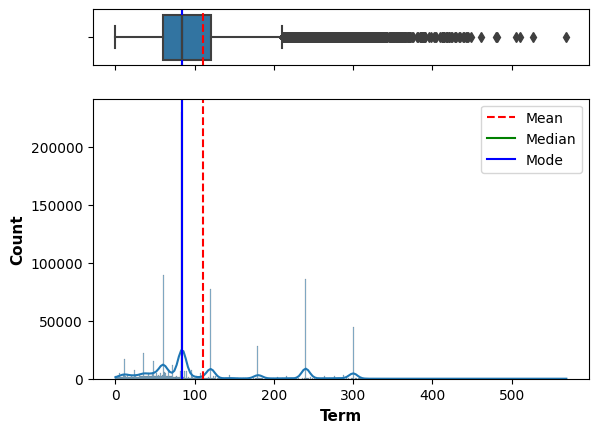

In [81]:
hist_box_plot("Term", df)

## `NoEmp` [Int - Skewed]

In [82]:
df.NoEmp.nunique()

599

In [83]:
print(sorted(df.NoEmp.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222,

☝️ `0` seems a bit weird but explainable...

In [84]:
df.NoEmp.value_counts(normalize=True).head(20)

NoEmp
1     0.171557
2     0.153809
3     0.100846
4     0.081904
5     0.067086
6     0.050892
10    0.035070
7     0.035027
8     0.034879
12    0.023157
15    0.020395
9     0.020165
20    0.015886
11    0.013114
14    0.011875
25    0.011064
13    0.010400
30    0.009605
18    0.008744
16    0.008726
Name: proportion, dtype: float64

## `NewExist` ➡️ One-Hot-Encoding (quasi-binary imbalanced)

### Issue With `NaN` Encoding

In [85]:
df.NewExist.value_counts(normalize=True, dropna=False)

NewExist
1.0    0.717191
2.0    0.281508
0.0    0.001150
NaN    0.000151
Name: proportion, dtype: float64

As a reminder, from the documentation:
- *Existing Business* is encoded as `1.0`.
- *New Business* is encoded as `2.0`

☝️ **`NaN`s are probably encoded as `0.0` though there are also encoded as `np.nan`**

### Considered Options

1. We can **drop the `0.0` and `np.nan`, making our column a binary one**, as there are really a few missing values. This could **simplify our job, especially if we're convinced it's a good idea to stratify according to this variable**.
2. We can **encode the melting of them as `missing`**.
3. ➡️ "Impute" them as "most_frequent" (2 successive `SimpleImputer`?)

In [86]:
def encode_NewExist(x: float) -> bool:
    if x > 1.5:
        return True
    return False

In [87]:
df.NewExist = df.NewExist.map(encode_NewExist)

## `CreateJob` 🟠 [Int - Skewed with huge mode 0]

In [88]:
df.CreateJob.nunique()

246

In [89]:
print(sorted(df.CreateJob.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 177, 179, 180, 182, 183, 184, 186, 189, 190, 195, 198, 200, 205, 206, 210, 214, 220, 221, 222, 223, 225, 226, 235, 240, 250, 252, 255, 256, 264, 270, 280, 300, 303, 310, 320, 350, 360, 363, 365, 375, 386, 397, 400, 409, 433, 450, 451, 452, 453, 454, 455, 456, 457, 458, 480, 500, 569, 600, 750,

In [90]:
df.CreateJob.value_counts(normalize=True).head(20)

CreateJob
0     0.699804
1     0.070261
2     0.064319
3     0.032037
4     0.022812
5     0.020788
10    0.012904
6     0.012244
8     0.008206
7     0.007089
15    0.006007
20    0.004983
12    0.004773
9     0.003704
25    0.002620
11    0.002311
30    0.002267
14    0.002114
13    0.002030
18    0.001608
Name: proportion, dtype: float64

🔎 It's really **highly skewed with a mode to 0**.

In [91]:
# # This makes all crash...
# hist_box_plot("CreateJob", df)

## `RetainedJob` 🟠 [Int - Skewed with huge mode 0]

In [92]:
df.RetainedJob.nunique()

358

In [93]:
print(sorted(df.RetainedJob.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 217, 219, 220, 221, 223, 225, 226, 229, 230, 231, 232,

In [94]:
df.RetainedJob.value_counts(normalize=True).head(20)

RetainedJob
0     0.489775
1     0.098751
2     0.085472
3     0.055568
4     0.044116
5     0.036287
6     0.026465
7     0.018384
8     0.017459
10    0.017170
12    0.010650
9     0.009715
15    0.009396
20    0.007029
11    0.006343
14    0.005336
13    0.004968
25    0.004577
16    0.003816
18    0.003746
Name: proportion, dtype: float64

🔎 Less than previously, it's really **highly skewed with a mode to 0**.

## `FranchiseCode` ➡️ binary?

In [95]:
df.FranchiseCode.nunique()

2768

In [96]:
df.FranchiseCode.unique()

array([    1,     0, 15100, ...,  2899, 18701, 15930])

In [97]:
df.FranchiseCode.value_counts(normalize=True).head(20)

FranchiseCode
1        0.710188
0        0.232230
78760    0.003751
68020    0.002137
50564    0.001150
21780    0.001116
25650    0.000795
79140    0.000733
22470    0.000684
17998    0.000674
52000    0.000641
24850    0.000597
10528    0.000484
67750    0.000467
9050     0.000420
21420    0.000412
10465    0.000406
72590    0.000386
52875    0.000370
38605    0.000361
Name: proportion, dtype: float64

### Processing

📄 As a reminder from the documentation, `0` or `1` means, **no franchise**, which leads us to this distribution.

In [98]:
def is_franchise(n: int) -> bool:
    return n not in (0, 1)

In [99]:
(df.FranchiseCode
 .map(is_franchise)
 .value_counts(normalize=True)
 .mul(100)
)

FranchiseCode
False    94.241793
True      5.758207
Name: proportion, dtype: float64

In [100]:
df.FranchiseCode = df.FranchiseCode.map(is_franchise)

In [101]:
df = df.rename(columns = {"FranchiseCode": "Franchise"})

## `UrbanRural` ➡️ One-Hot-Encoding (ternary)

In [102]:
df.UrbanRural.nunique()

3

In [103]:
df.UrbanRural.value_counts(normalize=True)

UrbanRural
1    0.523453
0    0.359387
2    0.117161
Name: proportion, dtype: float64

👉 **Ternary encoding** (0: missing values)

In [104]:
df.UrbanRural = df.UrbanRural.map({0: "M", 1: "U", 2: "R"})

## `RevLineCr` ➡️ One-Hot-Encoding

In [105]:
quantify_NaNs(df, "RevLineCr")

Nan Values for feature: RevLineCr
Number: 4,528
Proportion: 0.50%
---------------------------------


In [106]:
df.RevLineCr.value_counts(normalize=True, dropna=False)

RevLineCr
N      0.467403
0      0.286500
Y      0.223990
T      0.016999
NaN    0.005036
1      0.000026
R      0.000016
`      0.000012
2      0.000007
C      0.000002
5      0.000001
-      0.000001
4      0.000001
.      0.000001
3      0.000001
A      0.000001
7      0.000001
,      0.000001
Q      0.000001
Name: proportion, dtype: float64

### Ternarty Encoding

N, Y, 0 & others...

In [107]:
def encode_RevLineCr(x: 'object') -> str:
    if x in ("N", "Y"):
        return x
    return "Unknown"

In [108]:
df.RevLineCr = df.RevLineCr.map(encode_RevLineCr)

In [109]:
df.RevLineCr.value_counts()

RevLineCr
N          420258
Unknown    277479
Y          201397
Name: count, dtype: int64

## `LowDoc` ➡️ One-Hot-Encoding

In [110]:
quantify_NaNs(df, "LowDoc")

Nan Values for feature: LowDoc
Number: 2,582
Proportion: 0.29%
------------------------------


In [111]:
df.LowDoc.value_counts(normalize=True, dropna=False)

LowDoc
N      0.870607
Y      0.122713
NaN    0.002872
0      0.001658
C      0.000843
S      0.000671
A      0.000553
R      0.000083
1      0.000001
Name: proportion, dtype: float64

### Impute with inferring "less_frequent" (to balance) - Is it worth it???

In [112]:
def encode_LowDoc(s: "object") -> str:
    if s == "N":
        return s
    return "Y"

In [113]:
df.LowDoc = df.LowDoc.map(encode_LowDoc)

In [114]:
df.LowDoc.value_counts()

LowDoc
N    782792
Y    116342
Name: count, dtype: int64

## `GrAppv` 🟠 [float]

In [115]:
df.GrAppv.nunique()

22128

In [116]:
df.GrAppv.unique()

array(['$60,000.00 ', '$40,000.00 ', '$287,000.00 ', ..., '$12,480.00 ',
       '$62,425.00 ', '$1,086,300.00 '], dtype=object)

In [117]:
def amount_to_float(s: str) -> float:
    """Converts a 'string' amount in $ to its float value"""
    return float(s[1:].replace(',', ''))

In [118]:
df.GrAppv = df.GrAppv.map(amount_to_float)

/home/greg/projects/loan_approval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


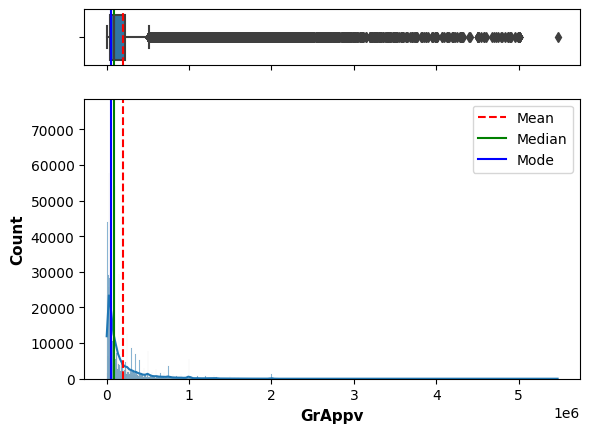

In [119]:
hist_box_plot("GrAppv", df)

## `SBA_Appv` 🟠

In [120]:
df.SBA_Appv.nunique()

38326

In [121]:
df.SBA_Appv.unique()

array(['$48,000.00 ', '$32,000.00 ', '$215,250.00 ', ..., '$9,984.00 ',
       '$34,246.00 ', '$715,674.00 '], dtype=object)

In [122]:
df.SBA_Appv = df.SBA_Appv.map(amount_to_float)

/home/greg/projects/loan_approval/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


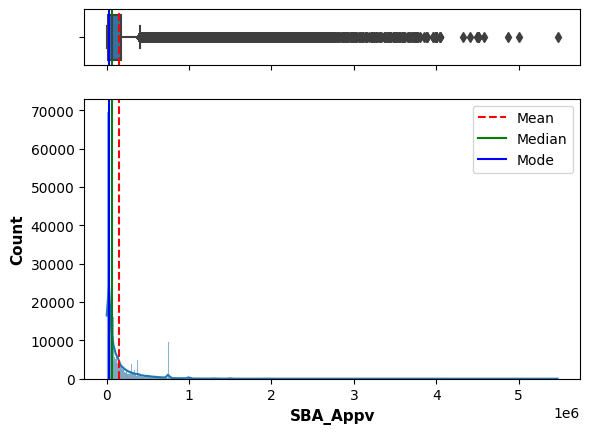

In [123]:
hist_box_plot("SBA_Appv", df)

### ❌ Draw a `FacetGrid` with crossing this with the target.

# Check-up & Export

## Dropping `ApprovalDate` and `ApprovalFY`

In [124]:
df = df.drop(columns=["ApprovalDate", "ApprovalFY"])

In [125]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState',
       'SameState', 'NAICS', 'ApprovalMonth', 'ApprovalDoW', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'Franchise', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv', 'Recession'],
      dtype='object')

## Reordering Columns

In [126]:
df = df[['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 'SameState', 'NAICS',
         'ApprovalMonth', 'ApprovalDoW', 'Recession', 'Term',
         'NewExist', 'NoEmp', 'CreateJob', 'RetainedJob',
         'Franchise', 'UrbanRural', 'RevLineCr', 'LowDoc',
         'GrAppv', 'SBA_Appv', 'MIS_Status']]

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 899134 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  899134 non-null  int64  
 1   Name           899120 non-null  object 
 2   City           899134 non-null  object 
 3   State          899120 non-null  object 
 4   Bank           899134 non-null  object 
 5   BankState      899134 non-null  object 
 6   SameState      899134 non-null  bool   
 7   NAICS          899134 non-null  object 
 8   ApprovalMonth  899134 non-null  int32  
 9   ApprovalDoW    899134 non-null  int32  
 10  Recession      899134 non-null  bool   
 11  Term           899134 non-null  int64  
 12  NewExist       899134 non-null  bool   
 13  NoEmp          899134 non-null  int64  
 14  CreateJob      899134 non-null  int64  
 15  RetainedJob    899134 non-null  int64  
 16  Franchise      899134 non-null  bool   
 17  UrbanRural     899134 non-null  ob

## ❌ Check-Out (NaN in State)

In [128]:
df.nunique()

LoanNr_ChkDgt    899134
Name             779554
City              32581
State                51
Bank               5803
BankState            57
SameState             2
NAICS                21
ApprovalMonth        12
ApprovalDoW           7
Recession             2
Term                412
NewExist              2
NoEmp               599
CreateJob           246
RetainedJob         358
Franchise             2
UrbanRural            3
RevLineCr             3
LowDoc                2
GrAppv            22128
SBA_Appv          38326
MIS_Status            2
dtype: int64

In [129]:
df.MIS_Status.value_counts(dropna=False)

MIS_Status
P I F     739579
CHGOFF    157558
NaN         1997
Name: count, dtype: int64

## Missing Values in Target

👉 **We'll separate the dataset**:
- keep in `df` features with known labels
- **keep for later features with missing labels**, as an additional "test set". 

In [130]:
df_na_target = df.query("MIS_Status.isna()")
df_na_target

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,SameState,NAICS,ApprovalMonth,ApprovalDoW,...,NoEmp,CreateJob,RetainedJob,Franchise,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,MIS_Status
343,1002585010,"Chinaberry, LTD",Saratoga Springs,NY,KEYBANK NATIONAL ASSOCIATION,OH,False,unknown,5,0,...,3,0,0,False,M,Unknown,N,30000.0,15000.0,NaN
611,1004503009,SMITHFIELD GLASS INC,DANIELSON,CT,Missing,Missing,False,unknown,7,0,...,30,0,0,False,M,N,N,300000.0,300000.0,NaN
738,1005264007,AMERICAN CERTIFIED HOME INSPEC,BOISE,ID,WELLS FARGO BANK NATL ASSOC,SD,False,unknown,3,0,...,1,0,0,False,M,Unknown,N,10000.0,5000.0,NaN
740,1005273003,"GENERAL SOLAR COMPANY, INC.",SIOUX CITY,IA,Missing,Missing,False,unknown,7,3,...,3,0,0,False,M,N,N,350000.0,350000.0,NaN
833,1005845000,SPROUT KIDS INC.,HUNTINGTON,NY,JPMORGAN CHASE BANK NATL ASSOC,IL,False,wholesale_trade,3,0,...,1,0,0,False,M,N,N,25000.0,12500.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892340,9855003006,PATHCO,ALAMEDA,CA,WELLS FARGO BANK NATL ASSOC,SD,False,unknown,12,3,...,1,0,0,False,M,Unknown,N,50000.0,25000.0,NaN
893791,9879293006,YAMA SEAFOOD L.A.,SAN GABRIEL,CA,WELLS FARGO BANK NATL ASSOC,SD,False,unknown,1,0,...,4,0,0,False,M,Unknown,N,25000.0,12500.0,NaN
894290,9889203005,SKY PILOT RESTORATIONS,PORTLAND,OR,WELLS FARGO BANK NATL ASSOC,SD,False,unknown,1,4,...,1,0,0,False,M,Unknown,N,10000.0,5000.0,NaN
896318,9932493007,"SMITH, CURTIS",RICHMOND,VA,FIRST COMMUNITY BANK,VA,True,unknown,1,3,...,1,0,0,False,M,N,Y,3500.0,2800.0,NaN


In [131]:
df = df.query("not MIS_Status.isna()")

In [132]:
# Check unique
df.nunique()

LoanNr_ChkDgt    897137
Name             778650
City              32566
State                51
Bank               5802
BankState            57
SameState             2
NAICS                21
ApprovalMonth        12
ApprovalDoW           7
Recession             2
Term                412
NewExist              2
NoEmp               598
CreateJob           246
RetainedJob         357
Franchise             2
UrbanRural            3
RevLineCr             3
LowDoc                2
GrAppv            22101
SBA_Appv          38288
MIS_Status            2
dtype: int64

In [133]:
# Check missing
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897137 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  897137 non-null  int64  
 1   Name           897123 non-null  object 
 2   City           897137 non-null  object 
 3   State          897124 non-null  object 
 4   Bank           897137 non-null  object 
 5   BankState      897137 non-null  object 
 6   SameState      897137 non-null  bool   
 7   NAICS          897137 non-null  object 
 8   ApprovalMonth  897137 non-null  int32  
 9   ApprovalDoW    897137 non-null  int32  
 10  Recession      897137 non-null  bool   
 11  Term           897137 non-null  int64  
 12  NewExist       897137 non-null  bool   
 13  NoEmp          897137 non-null  int64  
 14  CreateJob      897137 non-null  int64  
 15  RetainedJob    897137 non-null  int64  
 16  Franchise      897137 non-null  bool   
 17  UrbanRural     897137 non-null  ob

## Droping Rows With Missing State

In [134]:
df = df.dropna(subset=["State"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897124 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  897124 non-null  int64  
 1   Name           897110 non-null  object 
 2   City           897124 non-null  object 
 3   State          897124 non-null  object 
 4   Bank           897124 non-null  object 
 5   BankState      897124 non-null  object 
 6   SameState      897124 non-null  bool   
 7   NAICS          897124 non-null  object 
 8   ApprovalMonth  897124 non-null  int32  
 9   ApprovalDoW    897124 non-null  int32  
 10  Recession      897124 non-null  bool   
 11  Term           897124 non-null  int64  
 12  NewExist       897124 non-null  bool   
 13  NoEmp          897124 non-null  int64  
 14  CreateJob      897124 non-null  int64  
 15  RetainedJob    897124 non-null  int64  
 16  Franchise      897124 non-null  bool   
 17  UrbanRural     897124 non-null  ob

## 💿 Exports

In [135]:
df.to_csv("../data/cleaned_dataset.csv")

In [136]:
df_na_target.to_csv("../data/cleaned_test.csv")

## 📀 Tuning Dataset & Light Export

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897124 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LoanNr_ChkDgt  897124 non-null  int64  
 1   Name           897110 non-null  object 
 2   City           897124 non-null  object 
 3   State          897124 non-null  object 
 4   Bank           897124 non-null  object 
 5   BankState      897124 non-null  object 
 6   SameState      897124 non-null  bool   
 7   NAICS          897124 non-null  object 
 8   ApprovalMonth  897124 non-null  int32  
 9   ApprovalDoW    897124 non-null  int32  
 10  Recession      897124 non-null  bool   
 11  Term           897124 non-null  int64  
 12  NewExist       897124 non-null  bool   
 13  NoEmp          897124 non-null  int64  
 14  CreateJob      897124 non-null  int64  
 15  RetainedJob    897124 non-null  int64  
 16  Franchise      897124 non-null  bool   
 17  UrbanRural     897124 non-null  ob

In [138]:
nom_cols = ["Name", "City", "Bank",
            "State", "BankState", "NAICS",
            "UrbanRural", "RevLineCr", "LowDoc"]
for col in nom_cols:
    df[col] = df[col].astype("category")

df.ApprovalMonth = df.ApprovalMonth.astype("uint8")
df.ApprovalDoW = df.ApprovalDoW.astype("uint8")

int16_cols = ["Term", "NoEmp", "CreateJob", "RetainedJob"]
for col in int16_cols:
    df[col] = df[col].astype("uint16")

df.GrAppv = df.GrAppv.astype("uint32")
df.SBA_Appv = df.SBA_Appv.astype("uint32")

df.info()        

<class 'pandas.core.frame.DataFrame'>
Index: 897124 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   LoanNr_ChkDgt  897124 non-null  int64   
 1   Name           897110 non-null  category
 2   City           897124 non-null  category
 3   State          897124 non-null  category
 4   Bank           897124 non-null  category
 5   BankState      897124 non-null  category
 6   SameState      897124 non-null  bool    
 7   NAICS          897124 non-null  category
 8   ApprovalMonth  897124 non-null  uint8   
 9   ApprovalDoW    897124 non-null  uint8   
 10  Recession      897124 non-null  bool    
 11  Term           897124 non-null  uint16  
 12  NewExist       897124 non-null  bool    
 13  NoEmp          897124 non-null  uint16  
 14  CreateJob      897124 non-null  uint16  
 15  RetainedJob    897124 non-null  uint16  
 16  Franchise      897124 non-null  bool    
 17  UrbanRural     

In [139]:
df.to_csv("../data/light_dataset.csv")

In [140]:
df.nunique()

LoanNr_ChkDgt    897124
Name             778638
City              32562
State                51
Bank               5801
BankState            57
SameState             2
NAICS                21
ApprovalMonth        12
ApprovalDoW           7
Recession             2
Term                412
NewExist              2
NoEmp               598
CreateJob           246
RetainedJob         357
Franchise             2
UrbanRural            3
RevLineCr             3
LowDoc                2
GrAppv            22101
SBA_Appv          38288
MIS_Status            2
dtype: int64

# 🧪 Statistical Tests

## $\chi^2$

### Tests

### Function

In [141]:
def check_nominal_corr(df: pd.DataFrame, col1: str, col2: str, alpha: float = 0.05):
    """Perform a chi-square test between col1 and col2 and assess the strength of association."""
    print(f"TESTING CORRELATIONS BETWEEN {col1} AND {col2}")
    ct = pd.crosstab(df[col1], df[col2])
    # display(ct)
    stat, p, dof, expected = chi2_contingency(ct)

    if np.any(expected < 5):
        print("Warning: Some expected frequencies are less than 5.")
        ct_exp = pd.DataFrame(expected, columns=ct.columns, index=ct.index)
        display(ct_exp)

    if p < alpha:
        c = cramers_v(ct, stat)
        print(f"Significant correlation between {col1} and {col2} with p-value {p:.2e}. Cramér's V: {c:.3f}",
              end="\n\n")
        # Optionally, provide interpretation of Cramér's V value
    else:
        print(f"No significant correlation between {col1} and {col2} (p-value {p:.2e}).",
              end="\n\n")

    # Consider returning the results for further use
    return {'p_value': p, 'cramers_v': c if p < alpha else None}

### Test

In [142]:
# A redéfinir
nom_cols = []

In [143]:
for nom_col in nom_cols:
    check_nominal_corr(df, nom_col, "MIS_Status")

In [144]:
check_nominal_corr(df, "State", "BankState")

TESTING CORRELATIONS BETWEEN State AND BankState


BankState,AK,AL,AN,AR,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
State,,,,,,,,,,,,,,,,,,,,,
AK,3.854447,32.485569,0.002679,16.904389,10.599060,316.142340,28.336481,26.536489,10.722274,65.688993,...,15.050826,127.914608,50.871202,77.571083,0.002679,12.725836,28.628444,41.255173,5.373190,5.804438
AL,13.409562,113.016796,0.009319,58.810109,36.873966,1099.854335,98.582180,92.320036,37.302625,228.530995,...,52.361591,445.012953,176.980128,269.868602,0.009319,44.272988,99.597915,143.526112,18.693246,20.193552
AR,10.158225,85.614279,0.007059,44.550768,27.933353,833.179127,74.679539,69.935740,28.258077,173.120429,...,39.665784,337.113281,134.068798,204.435151,0.007059,33.538377,75.448995,108.726181,14.160805,15.297340
AZ,28.269153,238.254547,0.019645,123.979588,77.735261,2318.640286,207.824443,194.623004,78.638931,481.773953,...,110.385249,938.146923,373.097819,568.919168,0.019645,93.333390,209.965748,302.572273,39.407868,42.570713
CA,209.295034,1763.954254,0.145445,917.901987,575.524982,17166.410679,1538.660294,1440.921404,582.215442,3566.887708,...,817.254201,6945.715319,2762.287202,4212.080738,0.145445,691.008135,1554.513775,2240.140453,291.762222,315.178831
CO,33.039493,278.459326,0.022960,144.900792,90.852865,2709.904256,242.894229,227.465084,91.909027,563.071941,...,129.012446,1096.456555,436.057018,664.922664,0.022960,109.083135,245.396873,353.630486,46.057834,49.754400
CT,19.451885,163.941948,0.013518,85.309831,53.489305,1595.446593,143.003122,133.919268,54.111116,331.506623,...,75.955624,645.534937,256.727034,391.470878,0.013518,64.222312,144.476545,208.198704,27.116387,29.292728
DC,2.587276,21.805753,0.001798,11.346974,7.114558,212.208737,19.020701,17.812466,7.197265,44.093361,...,10.102781,85.861949,34.147003,52.069145,0.001798,8.542145,19.216679,27.692299,3.606723,3.896196
DE,3.517604,29.646631,0.002444,15.427101,9.672800,288.514421,25.860134,24.217445,9.785246,59.948382,...,13.735523,116.736053,46.425529,70.792087,0.002444,11.613716,26.126582,37.649852,4.903623,5.297184


Significant correlation between State and BankState with p-value 0.00e+00. Cramér's V: 0.639



{'p_value': 0.0, 'cramers_v': 0.6393952016314448}

## ANOVA

### Function

In [145]:
def do_ANOVA_test(df: pd.DataFrame, col1: str, col2: str,
                  alpha: float = 0.05) -> None:
    """Perform an ANOVA test between col1 and col2"""
    result = statsmodels.formula.api.ols(f'{col1} ~ {col2}', data=df).fit()
    display(statsmodels.api.stats.anova_lm(result))

### Tests

In [146]:
do_ANOVA_test(df, "CreateJob", "MIS_Status")

,df,sum_sq,mean_sq,F,PR(>F)
MIS_Status,1.0,7.133346e+06,7.133346e+06,127.063014,1.807918e-29
Residual,897122.0,5.036463e+10,5.614022e+04,NaN,NaN
